In [1]:
#!pip install qiskit
#!pip install qiskit_machine_learning
#!pip install pylatexenc

     |████████████████████████████████| 6.0MB 5.2MB/s 
     |████████████████████████████████| 18.0MB 135kB/s 
     |████████████████████████████████| 235kB 34.6MB/s 
     |████████████████████████████████| 215kB 29.7MB/s 
     |████████████████████████████████| 2.1MB 27.2MB/s 
     |████████████████████████████████| 1.0MB 31.0MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 194kB 22.0MB/s 
     |████████████████████████████████| 112kB 37.2MB/s 
     |████████████████████████████████| 614kB 31.9MB/s 
     |████████████████████████████████| 3.2MB 18.8MB/s 
     |████████████████████████████████| 6.3MB 21.4MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10491 sha256=140a5786b6ec3e61861aa3bd13f0cc72e84254bf16cb84d19a1b96e18eb6caca
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel for python-constraint: filename=python_constraint-1.4.0-

In [25]:
#Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B,SLSQP

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError
import pylatexenc

from sklearn.metrics import confusion_matrix

In [48]:
#Initiating the instance
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)

In [49]:
#Reading the data and removing extra column unnamed
data = pd.read_csv("outputNH3.csv")
data.head()
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp,NH3_Y,Date
0,38,25,48,2250,8.3,22.150,0.98,2013-01-10 00:00:00
1,150,28,41,2190,7.4,22.975,0.59,2013-01-24 00:00:00
2,130,26,41,2090,7.2,22.750,0.57,2013-01-31 00:00:00
3,180,29,48,2500,7.6,25.200,0.78,2013-02-07 00:00:00
4,170,28,44,2040,7.3,24.175,0.72,2013-03-07 00:00:00


In [50]:
#Filtering data so it runs faster
data = data.iloc[0:10,]

In [51]:
# Creating a binary variable based on median value
data['NH3_Y_binary'] = np.where(data['NH3_Y'] >= data['NH3_Y'].median(), 1, 0)
data.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp,NH3_Y,Date,NH3_Y_binary
0,38,25,48,2250,8.3,22.150,0.98,2013-01-10 00:00:00,1
1,150,28,41,2190,7.4,22.975,0.59,2013-01-24 00:00:00,0
2,130,26,41,2090,7.2,22.750,0.57,2013-01-31 00:00:00,0
3,180,29,48,2500,7.6,25.200,0.78,2013-02-07 00:00:00,1
4,170,28,44,2040,7.3,24.175,0.72,2013-03-07 00:00:00,1


In [52]:
#Filtering relevant independent variables
X = data[['BOD','NH3-N','TN','MLSS','PH','AT_Temp']]
X.head()

,BOD,NH3-N,TN,MLSS,PH,AT_Temp
0,38,25,48,2250,8.3,22.150
1,150,28,41,2190,7.4,22.975
2,130,26,41,2090,7.2,22.750
3,180,29,48,2500,7.6,25.200
4,170,28,44,2040,7.3,24.175


In [53]:
# Creating binary variable
y = data['NH3_Y_binary']

In [54]:
# Creating a dummy varible for VQC
y_new = np.ones((len(data),2))
print(y_new)

y_new[:,1] = np.where(y == 1, 1, 0)
y_new[:,0] = np.where(y == 0, 1, 0)
y_new

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [55]:
# Y variable for regression and scaling it from -1 to +1
y_linear = data['NH3_Y']
y_linear_scaled = np.interp(y_linear, (y_linear.min(), y_linear.max()), (-1, +1))
y_linear_scaled

array([ 0.14666667, -0.89333333, -0.94666667, -0.38666667, -0.54666667,
        1.        , -0.73333333, -1.        , -0.28      , -0.6       ])

In [56]:
# construct QNN
num_inputs = 6
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [57]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X.iloc[0,:], np.random.rand(opflow_qnn.num_weights))

array([[0.21875]])

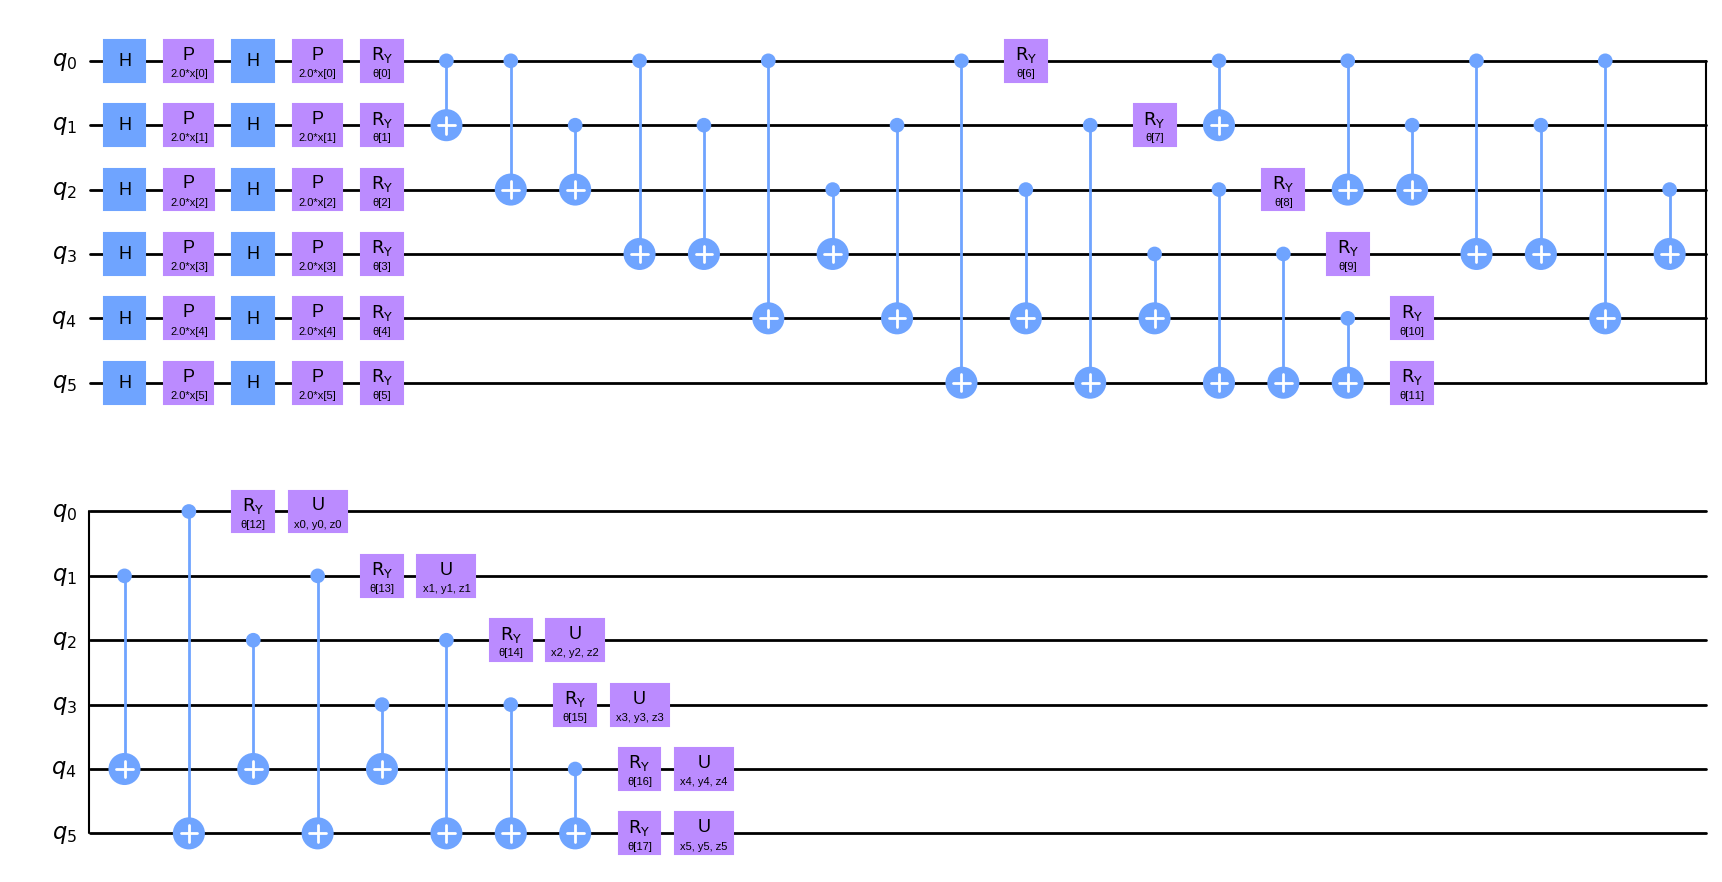

In [79]:
# construct feature map
feature_map = ZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=2)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
thetax=[]
thetay=[]
thetaz=[]
for i in range(num_inputs):
  thetax.append(Parameter('x' + str(i)))
  thetay.append(Parameter('y' + str(i)))
  thetaz.append(Parameter('z' + str(i)))
for i in range(num_inputs):
  qc.u(thetax[i],thetay[i],thetaz[i],i)

qc.decompose().draw(output='mpl')

In [80]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [81]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

VQC Regression

In [82]:
#Initiating regressor
vqr = VQR(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SLSQP(),
          quantum_instance=quantum_instance)

In [83]:
#fitting regressor
vqr.fit(X, y_linear_scaled)

In [102]:
#Predicting the value
y_VQR = vqr.predict(X)
y_VQR

array([[ 0.04101562],
       [-0.58203125],
       [-0.63671875],
       [-0.14648438],
       [-0.48242187],
       [ 0.5234375 ],
       [-0.4140625 ],
       [-0.67578125],
       [-0.74414062],
       [-0.4921875 ]])

In [89]:
# plot data
plt.plot(X.iloc[:,0], y_linear_scaled, 'bo')
# plot fitted line
plt.plot(X.iloc[:,0], y_VQR, 'go')
plt.show()

In [90]:
plt.plot(y_linear_scaled,y_VQR, 'bo')
x = np.linspace(-1, 1,100)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.plot(x,x,color="black")

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#MSE
mse = mean_squared_error(y_linear_scaled,y_VQR)
print(mse)
# R squared error
r2s = r2_score(y_linear_scaled,y_VQR)
print(r2s)

0.09271673014322918
0.7226131781041698
